# Auto Encoder

オートエンコーダ

入力したものをそのまま出力するニューラルネットワーク。  
**encoder**と**decoder**の2つの部分からなる。

- encoder：入力を低次元のベクトルに変換する
- decoder：encoderの出力を元の次元に戻す

入力を一度低次元の空間に埋め込み、そこから元のサイズに復元するイメージ。学習が完了したモデルは色々な用途で活用できる。例えば、encoderの出力は入力データの特徴を捉えた**潜在変数**として扱うことが出来る。

<br>

活用例

- ノイズ削除
- 次元削減
- 異常検知
- データ生成

<br>

ここではノーマルなオートエンコーダを実装してみる。  
MNISTを使って、何ができるか見てみよう。

In [1]:
import torch
from torch import nn, optim
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import numpy as np
from IPython.display import display
import matplotlib.pyplot as plt
import warnings

warnings.filterwarnings("ignore")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')


---

## 学習

まずはモデルを作ってみよう

In [2]:
mnist = datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=transforms.ToTensor()
)
dataloader = DataLoader(mnist, batch_size=64, shuffle=True)

def draw(model, n_images=10, width=800):
    """画像描画用関数"""
    model.eval()
    with torch.no_grad():
        x, _ = next(iter(dataloader))
        x = x.view(x.size(0), -1)[:n_images].to(device)
        y = model(x)
    img = torch.cat([x, y], dim=0).view(-1, 1, 28, 28).cpu()
    img = transforms.Resize((width // n_images))(img)
    img = torchvision.utils.make_grid(img, nrow=n_images)
    img = transforms.functional.to_pil_image(img)
    display(img)

### モデル実装

encoderとdecoderを実装し、それらを組み合わせる。適当に線形層とReLUを使っている。  
decoderは画像を出力するので、最後にsigmoidを入れて0~1に正規化する。

`z_dim`は潜在変数の次元数。encoderはMNISTの画像（28*28=784次元ベクトル）を潜在変数（`z_dim`次元ベクトル）に変換する。decoderはその逆。

In [3]:
class AutoEncoder(nn.Module):
    def __init__(self, z_dim):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(784, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, z_dim),
        )
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 784),
            nn.Sigmoid(),
        )

    def forward(self, x):
        z = self.encoder(x) # 潜在変数に変換
        y = self.decoder(z) # 画像に戻す
        return y

では学習させてみよう。MSEを損失関数として使い、入力と出力の差を取る。これが小さくなるように学習させる。

In [4]:

x, _ = next(iter(dataloader))

In [5]:
critetion = nn.MSELoss()

def train(model, n_epochs, optimizer):
    model.train()
    for epoch in range(n_epochs):
        for x, _ in dataloader:
            optimizer.zero_grad()
            x = x.flatten(1).to(device) # 28x28 -> 784
            y = model(x) # 画像を入力して画像を出力
            loss = critetion(y, x) # 出力と入力の誤差
            loss.backward() # 逆伝播
            optimizer.step() # パラメータ更新
        print(f'{epoch+1}epoch, loss:{loss.item()}')

In [6]:
z_dim = 10 # 潜在変数を10次元に設定（適当）
ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)

5エポック学習

In [7]:
train(ae, 5, optimizer)

1epoch, loss:0.023118989542126656
2epoch, loss:0.01764550618827343
3epoch, loss:0.015758806839585304
4epoch, loss:0.01914379931986332
5epoch, loss:0.015929270535707474


結果を見てみる

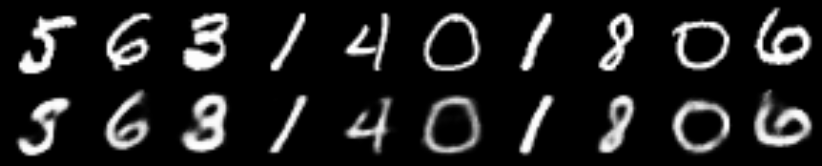

In [8]:
draw(ae)

上が入力、下が出力。  
入力をしっかりと復元できていることが分かる。

では、活用例を見てみる


---

## 次元削減

encoderは入力を低次元に圧縮しているので、そこを使えば次元削減ができる。

潜在変数の次元数を2にしてAEを学習し、そのencoderで次元削減した結果を散布図にしてみよう。

1epoch, loss:0.04655643180012703
2epoch, loss:0.04456200823187828
3epoch, loss:0.04566157981753349
4epoch, loss:0.03329959139227867
5epoch, loss:0.042356763035058975


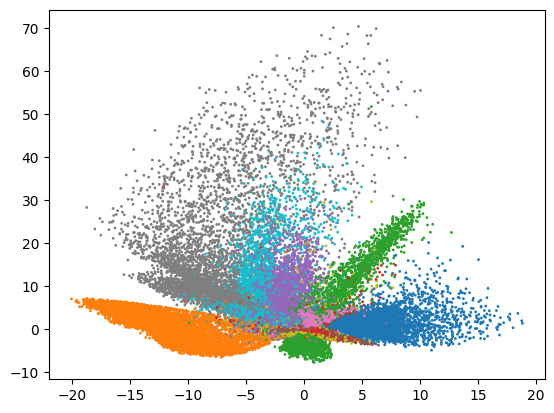

In [9]:
ae = AutoEncoder(2).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, 5, optimizer)

latents, labels = [], []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        latents.append(z.cpu())
        labels.append(label)
latents = torch.cat(latents, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(latents[:, 0], latents[:, 1], c=labels, s=1, cmap='tab10');

数字ごとに色を分けて描画した。  
同じ色がある程度固まっているため、encoderが数字の特徴を捉えていると判断できる。

### 学習しなかった場合

学習をしていないencoderで次元削減をするとどうなるのか

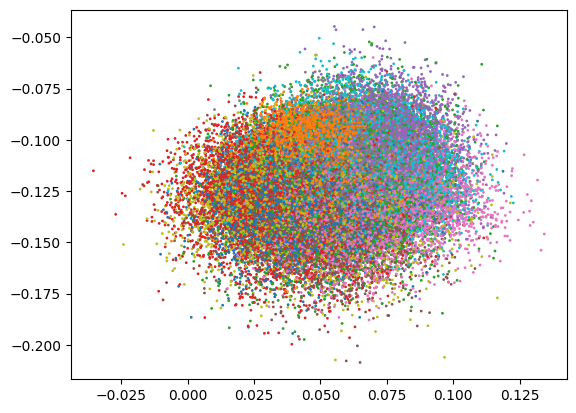

In [10]:
ae = AutoEncoder(z_dim).to(device)
latents, labels = [], []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        latents.append(z.cpu())
        labels.append(label)
latents = torch.cat(latents, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(latents[:, 0], latents[:, 1], c=labels, s=1, cmap='tab10');

このようにごちゃごちゃになる。  
ただよく見ると、ほんの少し色の偏りが見られると思う。encoderで、全てのデータに対して同じ演算で2次元に圧縮しているため、元のデータ（入力画像）が似ていれば2次元のベクトルも似たものになる。  

ここで、元の画像と、その白黒を反転させた画像をencoderで次元削減し、描画してみよう。

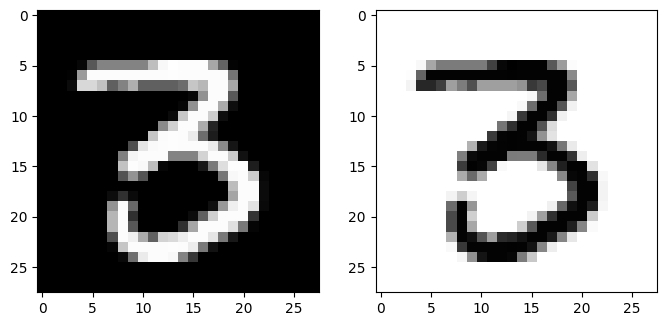

In [11]:
x = next(iter(dataloader))[0][0, 0] # 画像を1つ取り出す
reverse_x = 1 - x # 白黒反転
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8, 4))
ax1.imshow(x, cmap='gray')
ax2.imshow(reverse_x, cmap='gray');

左が元の画像。右が反転させた画像。  
描画させてみよう。

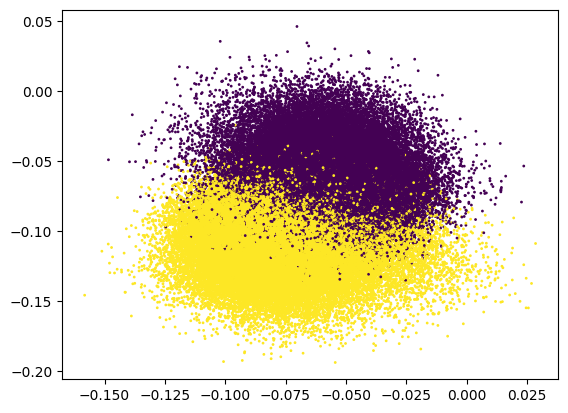

In [12]:
ae = AutoEncoder(z_dim).to(device)

latents, labels = [], []
ae.eval()
with torch.no_grad():
    for x, _ in dataloader:
        x = x.flatten(1).to(device)
        z = ae.encoder(x)
        latents.append(z.cpu())
        labels.append(torch.zeros(len(z)))

        reverse_x = 1 - x
        z = ae.encoder(reverse_x)
        latents.append(z.cpu())
        labels.append(torch.ones(len(z)))

latents = torch.cat(latents, dim=0)
labels = torch.cat(labels, dim=0)
plt.scatter(latents[:, 0], latents[:, 1], c=labels, s=1);

未学習でも違いが顕著に表れた。

元の画像は黒主体の画像で、反転すると白主体の画像になる。この2種類のデータ（ベクトル）はベクトル空間$\mathbb{R}^{784}$内である程度距離が離れているため、適当な関数（未学習のencoder）で2次元空間$\mathbb{R}^2$上に写像しても距離が離れる。  
一方で、その2種類の中での**数字の違いによる$\mathbb{R}^{784}$内の距離**は先程の2種類に比べて小さいものとなるため、適当な関数で2次元空間$\mathbb{R}^2$に写像してもあまり違いが表れない。  
オートエンコーダを学習させることで、そのencoderは$\mathbb{R}^{784}$内の画像が存在する領域と潜在空間$\mathbb{R}^2$の対応を正確に捉えられるようになる。


---

## ノイズ除去

AEはデータを低次元のベクトルに圧縮し、元のデータを復元する。一度低次元に圧縮している以上、事実として情報量が減っている。その情報は、データを表す上で重要でない情報（=ノイズ）とみることが出来る。

実際に例を見てみると、復元された画像は元の画像よりもぼやけている。どの程度ぼやけるかは潜在変数の次元数に依存する（低い方がぼやける）。例えば1次元に設定するとこうなる。

1epoch, loss:0.05627882108092308
2epoch, loss:0.04966869205236435
3epoch, loss:0.05017611384391785
4epoch, loss:0.04166419059038162
5epoch, loss:0.051462747156620026


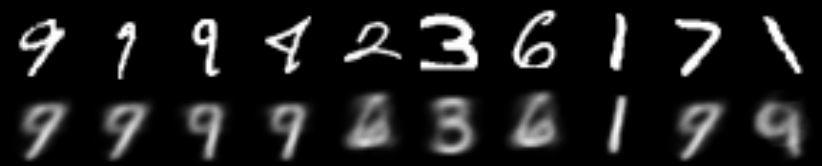

In [13]:
ae = AutoEncoder(1).to(device) # 潜在変数を1次元に設定
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
train(ae, 5, optimizer)
draw(ae)

かなりぼやけた画像になった


---

## 異常検知

入力と似た出力が行えるのは、入力が学習に使用したデータと同じ特徴を持っているときだけ。この性質を使って異常検知を行う。  
具体的な流れは以下

1. 正常なデータで学習させる
2. モデルに何らかのデータを入力する
3. モデルの出力と入力の誤差を計算する
4. 誤差が閾値を超えていたら異常と判定する

<br>

試しに、数字の0だけでモデルを学習させてみよう

In [14]:
z_dim = 10
ae = AutoEncoder(10).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5

ae.train()
for epoch in range(n_epochs):
    for x, labels in dataloader:
        if 0 not in labels:
            continue
        x = x[labels == 0] # 0だけ使用
        optimizer.zero_grad()
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        loss = critetion(y, x)
        loss.backward()
        optimizer.step()
    print(f'{epoch+1}epoch, loss:{loss.item()}')

1epoch, loss:0.030087074264883995
2epoch, loss:0.021964533254504204
3epoch, loss:0.013560472056269646
4epoch, loss:0.024043487384915352
5epoch, loss:0.012651427648961544


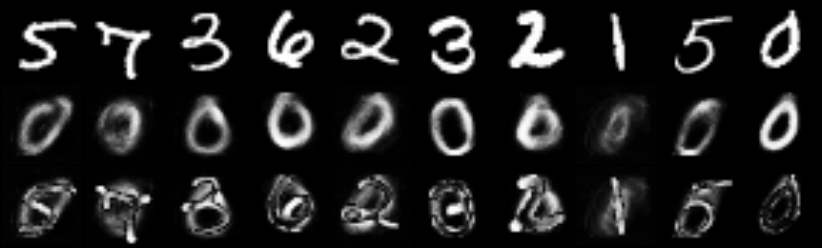

In [15]:
n_images = 10
width = 800

ae.eval()
with torch.no_grad():
    for x, labels in dataloader:
        if 0 not in labels[:n_images]:
            continue
        x = x[:n_images]
        x = x.view(x.size(0), -1).to(device)
        y = ae(x)
        break

x = x.view(n_images, 1, 28, 28).cpu()
y = y.view(n_images, 1, 28, 28).cpu()
diff = (x - y).abs()
diff = (diff - diff.min()) / (diff.max() - diff.min())
f = width // n_images
x = transforms.Resize((f))(x)
y = transforms.Resize((f))(y)
diff = transforms.Resize((f))(diff)
grid = torchvision.utils.make_grid(torch.cat([x, y, diff], dim=0), nrow=n_images)
img = transforms.functional.to_pil_image(grid)
display(img)

- 1段目：入力
- 2段目：出力
- 3段目：入力と出力の差

0以外の数値では上手く復元できていないのが分かる。というかどれも0っぽくなってしまっているね。これを見ると、入力と出力の差が大きいデータを異常と判定することができそう。

差の和を見てみる

In [16]:
print('label: diff')
for diff, label in zip(diff, labels):
    print(f'{label.item():>5}: {diff.sum().item():.3f} ')

label: diff
    5: 784.425 
    7: 843.347 
    3: 820.522 
    6: 681.703 
    2: 902.583 
    3: 642.052 
    2: 1021.238 
    1: 665.747 
    5: 578.952 
    0: 296.780 


0が他と比べて小さいのが分かる


---

## データ生成

decoderを使ってデータを生成する。潜在変数が何らかの分布に従っているという仮定が必要。  
具体的な手順は以下。

- AEを学習させる
- 潜在変数が従っている分布を求める
- その分布から潜在変数をサンプリングする
- decoderに潜在変数を入力してデータを生成する

<br>

とりあえず学習させる

1epoch, loss:0.04616928845643997
2epoch, loss:0.04106307402253151
3epoch, loss:0.04522436484694481
4epoch, loss:0.03526860848069191
5epoch, loss:0.041527193039655685


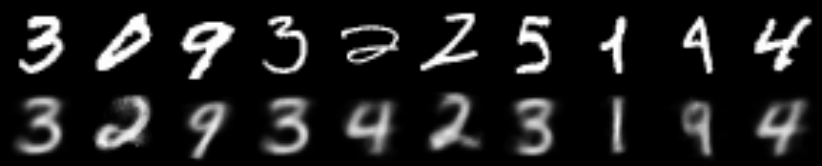

In [17]:
z_dim = 2

ae = AutoEncoder(z_dim).to(device)
optimizer = optim.Adam(ae.parameters(), lr=1e-3)
n_epochs = 5
train(ae, n_epochs, optimizer)
draw(ae)

### 潜在変数の分布を求める

まずは観察

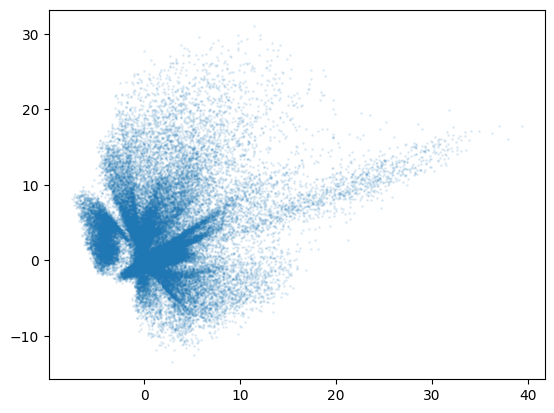

In [18]:
latents = []
ae.eval()
with torch.no_grad():
    for x, label in dataloader:
        x = x.view(x.size(0), -1).to(device)
        z = ae.encoder(x)
        latents.append(z.cpu())
latents = torch.cat(latents, dim=0)
plt.scatter(latents[:, 0], latents[:, 1], s=1, alpha=0.1);

複雑な形だが、適当に混合ガウス分布で近似してみる

estimated n_classes: 10


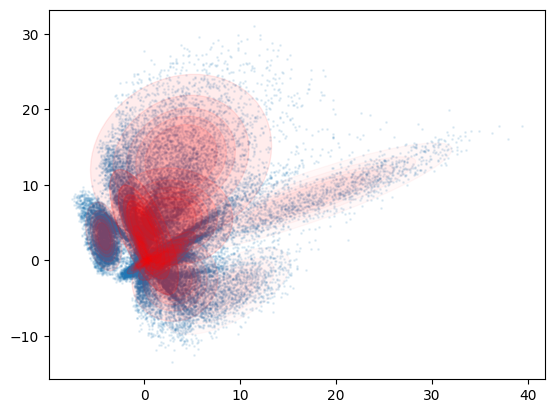

In [19]:
from sklearn.mixture import BayesianGaussianMixture
from matplotlib.patches import Ellipse

# 推定
vbgmm = BayesianGaussianMixture(n_components=10)
vbgmm.fit(latents)

# パラメータ取得
weights = vbgmm.weights_
means = torch.tensor(vbgmm.means_)
covs = torch.tensor(vbgmm.covariances_)
n_classes = len(weights)
print('estimated n_classes:', n_classes)

# 可視化
plt.scatter(latents[:, 0], latents[:, 1], s=1, alpha=0.1)
ax = plt.gca()
for pos, cov, w in zip(means, covs, weights):
    U, s, Vt = np.linalg.svd(cov)
    angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
    width, height = 2 * np.sqrt(s)
    for size in [0.8, 1.0, 1.2, 1.5, 2.0]:
        elipse = Ellipse(pos, size*width, size*height, angle, alpha=w, color='red')
        ax.add_patch(elipse)

この赤い範囲が推定された分布。ここから潜在変数をサンプリングする。

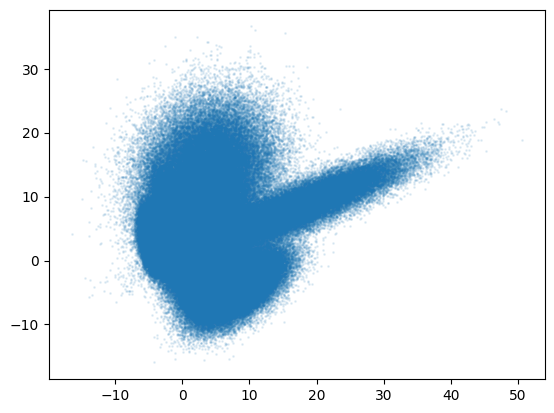

In [20]:
import pyro
import pyro.distributions as dist

n_samples = len(latents)
norms = [dist.MultivariateNormal(mean, cov) for mean, cov in zip(means, covs)]
z = []
for i, n in enumerate((weights * n_samples).astype(int)):
    with pyro.plate('', n_samples):
        z.append(pyro.sample('', norms[i]))
z = torch.cat(z, dim=0)
plt.scatter(z[:, 0], z[:, 1], s=1, alpha=0.1);

まあまあ実際の分布に近いデータが得られたはず。

この潜在変数をdecoderに入れると、学習させたデータに似ているデータ（手書き数字の画像）ができる。

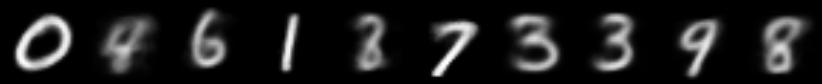

In [21]:
sample_z = z[torch.randint(0, len(z), (10,))] # ランダムに10個選ぶ
sample_z = torch.unsqueeze(sample_z, 0) # バッチ次元を追加
sample_z = sample_z.to(device).float() # GPUに転送 & float32に変換
sample_x = ae.decoder(sample_z) # 画像生成

img = sample_x.view(-1, 1, 28, 28).cpu()
img = transforms.Resize(80)(img)
img = torchvision.utils.make_grid(img, nrow=len(img))
img = transforms.functional.to_pil_image(img)
img

手書き数字が生成できた。

<br>

今回は、先にAEを学習させてから潜在変数の分布を求めたが、先に何らかの分布を定め、潜在変数がその分布に従うように学習することもできる。そのモデルはVAEと呼び、主に生成モデルとして様々な場面で活用されている。これについては別のノートブックでまとめる。